# How does network structure lead to network dynamics?

Here, we look at examples where studying neural variability through time would help us undrestanding computations in the brain.  

We look at the neural response during the drifting gratings stimulus in neuropixel visual coding data set because of its long duration (2 seconds).

In [1]:
import os

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache
import scipy.stats as stats
#import sys
#sys.path.append('data/')
from drifting_gratings75 import DriftingGratings75

manifest_path = os.path.join("/home/koosha/Allen_data/", "manifest.json")
cache = EcephysProjectCache.from_warehouse(manifest = manifest_path)
sessions = cache.get_session_table()
session_ids = sessions.index.tolist()
session_id = session_ids[30] 
session = cache.get_session_data(session_id)

start_time = 0
end_time = 2000
time_step = 1
high_contrast = 1
direction = 0
area_name = "VISp"
min_range = 20
n_trials = 75
ds = DriftingGratings75(session_id)
conds_all = ds.getConditions()
conds_lh = ds.divideContrast(conds_all)
conds_contrast = conds_lh [high_contrast] 
conds_dir = ds.divideDirection(conds_contrast)  
conds = conds_dir[direction]
key_list = list(conds.keys())
n_trials = len(key_list)
spikes = ds.getSpikes(area_name, min_range)
data = ds.getData(spikes,conds, start_time, end_time, time_step)[:, :-2]
data_trial = data.reshape([n_trials, end_time - start_time, data.shape[-1]])
trial_avg_fr = np.sum(data_trial, axis = 1) / ((end_time - start_time) / 1000)
#### picking the cherries:
sorted_inds = np.argsort(np.mean(trial_avg_fr, axis = 0))
example_neurons = [sorted_inds[-9], sorted_inds[-5], sorted_inds[-3]] 
v, v_times = ds.getVelocity()
trial_speed = np.zeros(n_trials)
for ci, cond in enumerate(key_list):
    trial_speed[ci] = np.mean(v[cond])
running_trials = np.where(trial_speed > 1)[0]
stat_trials = np.where(trial_speed <= 1)[0]

/home/koosha/.local/lib/python3.8/site-packages/hdmf/utils.py:577: FutureWarning: DynamicTable.__init__: Using positional arguments for this method is discouraged and will be deprecated in a future major release. Please use keyword arguments to ensure future compatibility.
  warnings.warn(msg, FutureWarning)
/home/koosha/.local/lib/python3.8/site-packages/hdmf/utils.py:577: FutureWarning: DynamicTable.__init__: Using positional arguments for this method is discouraged and will be deprecated in a future major release. Please use keyword arguments to ensure future compatibility.
  warnings.warn(msg, FutureWarning)


First, lets visualize the acitivity of some example neurons during the stiumlus averaged over all (75) repeated tirals for a given orientation (0 degree) and contrast (high).

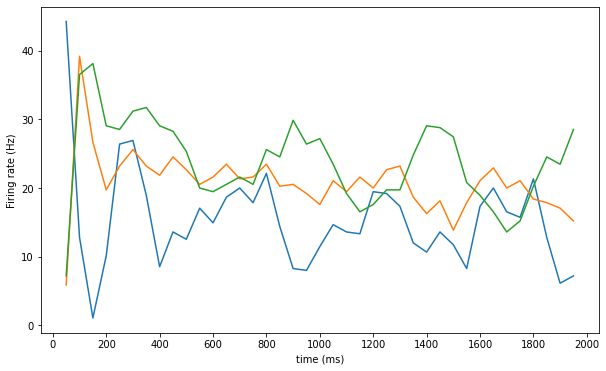

In [2]:
fr_window = 50
fr_slide = 50
num_window = ((end_time - start_time) - fr_window) // fr_slide 
fr_binned = np.zeros([data_trial.shape[0], num_window, data.shape[-1]])
for st_window in range(0, end_time - start_time - fr_window, fr_slide):
    fr_binned[:, st_window // fr_slide, :] = (1000 / fr_window) * np.sum(data_trial[:, st_window : st_window + fr_window, :], axis = 1)

plt.figure(figsize=(10,6))


for n in example_neurons:
    plt.plot(np.arange(start_time + fr_window, end_time, fr_slide), np.mean(fr_binned[:, :, n], axis = 0))
plt.xlabel('time (ms)')
plt.ylabel('Firing rate (Hz)')
plt.xticks(np.arange(start_time, end_time - start_time + 1, (end_time - start_time) // 10));

Does the activity follow a poisson process in each trail? We can look at the Fano factor for that. 

# Fano factor

Text(0, 0.5, 'Num trials')

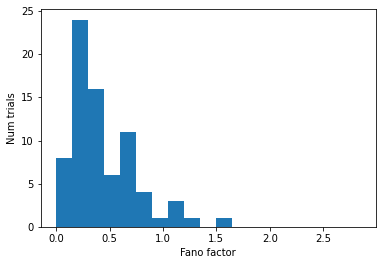

In [3]:
#####TODO:read spike times directly
mean_isis = np.zeros([n_trials, data.shape[-1]])
for n in range(data.shape[-1]):
    #n = example_neurons[n_ind]
    for tr in range(n_trials):
        spike_times = np.where(data_trial[tr, :, n] > 0)[0]
        if spike_times.size > 2:
            mean_isis[tr, n] = np.mean(np.diff(spike_times))

fr_window = 200
fr_slide = 200
num_window = 1 + (((end_time - start_time) - fr_window) // fr_slide)
fr_binned = np.zeros([data_trial.shape[0], num_window, data.shape[-1]])
for st_window in range(0, end_time - start_time - fr_window + 1, fr_slide):
    fr_binned[:, st_window // fr_slide, :] =  (mean_isis / fr_window) * np.sum(data_trial[:, st_window : st_window + fr_window, :], axis = 1)

response_means = np.mean(fr_binned[:, 4:], axis = 1)
response_vars = np.var(fr_binned[:, 4:], axis = 1)
fano = response_vars / (response_means + 10 ** -40)

plt.hist(fano[:, example_neurons[0]], bins = np.arange(0, 3, .15))
plt.xlabel("Fano factor")
plt.ylabel("Num trials")

The fano factor is less than 1 for almost all of the neurons. While this suggests less variabilty than expcted it has been shown before by Kara, Reinagel, and Reid (Neuron 2000). 

# Excersie: Check the variability in other cortical and sub-cortical regions. Compare the results with the Kara et al results. 

# Variability Over trials

First, let's look at the distribuation of firing rate (measured during the whole 2 seconds of each trial) over the 75 repeats for our three example neurons. 

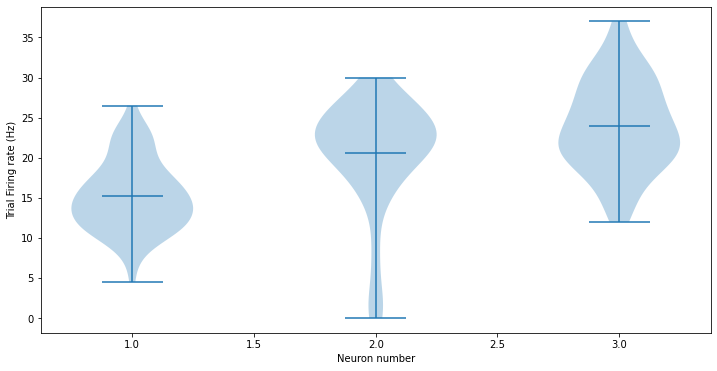

In [4]:
plt.figure(figsize=(12,6))
plt.violinplot(np.sum(data_trial / 2, axis = 1)[:, example_neurons], showmeans = True)
plt.ylabel("Trial Firing rate (Hz)")
plt.xlabel("Neuron number");

# TODO: Fano factor over trials.

# Over trials for running and stationary

One source of variability is animal's internal state which also affects neural responses in the visual cortex. 

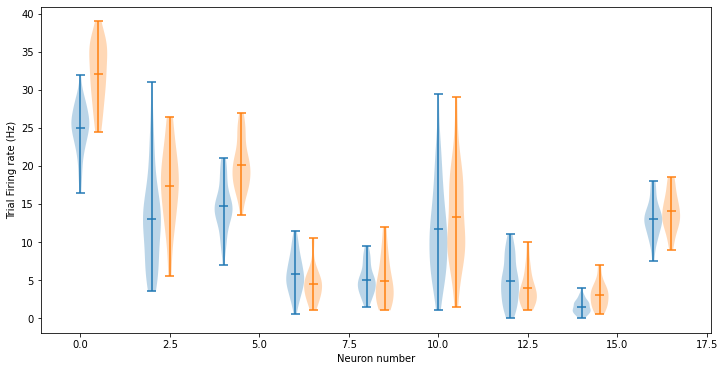

In [5]:
sc_trial = np.sum(data_trial, axis = 1) / 2
more_example_neurons = [sorted_inds[-13], sorted_inds[-9], sorted_inds[-7], sorted_inds[-11], sorted_inds[-5], sorted_inds[-3]] 
more_example_neurons = range(0, data.shape[-1], 6)
stat_pos = 2 * np.arange(len(more_example_neurons))
plt.figure(figsize=(12,6))
plt.violinplot(sc_trial[:, more_example_neurons][stat_trials], positions= stat_pos, showmeans = True)
plt.violinplot(sc_trial[:, more_example_neurons][running_trials], positions= stat_pos + .5, showmeans = True)
plt.ylabel("Trial Firing rate (Hz)")
plt.xlabel("Neuron number");

# Average population response over time 

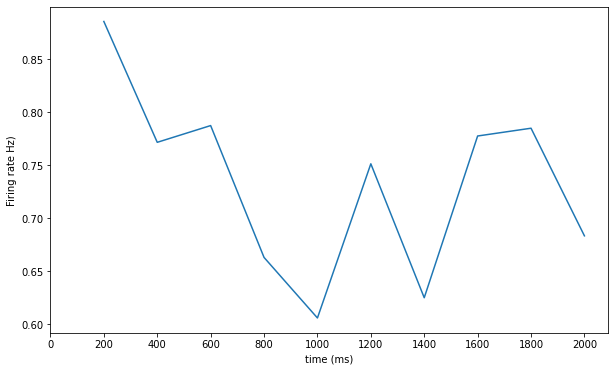

In [6]:
plt.figure(figsize=(10,6))
plt.plot(np.arange(start_time + fr_window, end_time + 1, fr_slide), np.mean(np.mean(fr_binned, axis = 0), axis = -1))
plt.xlabel('time (ms)')
plt.ylabel('Firing rate Hz)')
plt.xticks(np.arange(start_time, end_time - start_time + 1, (end_time - start_time) // 10));

# Encoding based on direction and contrast

load the data

In [7]:
key_list = list(conds_all.keys())
n_trials = len(key_list)
data = ds.getData(spikes, conds_all, start_time, end_time, time_step)[:, :-2]
data_trial = data.reshape([n_trials, (end_time - start_time), data.shape[-1]])
fr_window = 200
fr_slide = 200
num_window = 1 + (((end_time - start_time) - fr_window) // fr_slide)
fr_binned = np.zeros([data_trial.shape[0], num_window, data.shape[-1]])
for st_window in range(0, end_time - start_time - fr_window + 1, fr_slide):
    fr_binned[:, st_window // fr_slide, :] =  (1000 / fr_window) * np.sum(data_trial[:, st_window : st_window + fr_window, :], axis = 1)

Make initial feature matrix based on stimulus attributes and running speed

In [8]:
cond_matrix = np.zeros([n_trials, 3], dtype = int)
for c, cond_id in enumerate(key_list):
    cond_matrix[c, 0] = np.sin(np.pi * conds_all[cond_id][0] / 180)
    cond_matrix[c, 1] = np.cos(np.pi * conds_all[cond_id][0] / 180)
    cond_matrix[c, 0] = conds_all[cond_id][1]

trial_speed = np.zeros(n_trials)
for ci, cond in enumerate(key_list):
    trial_speed[ci] = np.mean(v[cond])

features = np.hstack([cond_matrix, trial_speed.reshape(-1, 1)])

let's look at the time bin of 1200 to 1400 ms after stimulus-onset.

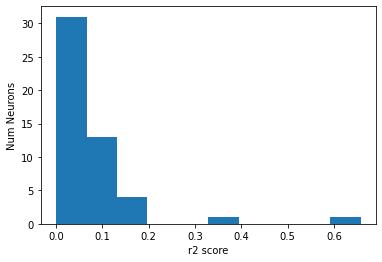

In [9]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

model = LinearRegression()
Y = fr_binned[:, 6, :] 
X = features
model.fit(X, Y)
y_pred = model.predict(X)
all_r2s = r2_score(Y, y_pred, multioutput = 'raw_values' )
plt.hist(all_r2s)
plt.xlabel("r2 score")
plt.ylabel("Num Neurons");

Now let's add the neural response in the previous time bin (1000 to 1200). to our model  

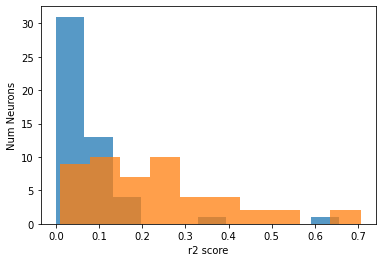

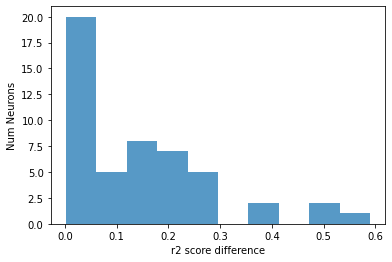

In [10]:
all_r2s_prev= np.zeros(data.shape[-1])
for n in range(fr_binned.shape[-1]):
    X2 = np.hstack([features, fr_binned[:, 5, n:n+1]])
    model.fit(X2, Y[:, n])
    y_pred = model.predict(X2)
    all_r2s_prev[n] = r2_score(Y[:, n], y_pred, multioutput = 'raw_values')[0]
plt.hist(all_r2s, alpha = .75)
plt.hist(all_r2s_prev, alpha = .75)
plt.xlabel("r2 score")
plt.ylabel("Num Neurons")
plt.show()
plt.hist(all_r2s_prev - all_r2s, alpha = .75)
plt.xlabel("r2 score difference")
plt.ylabel("Num Neurons");


# Is it because of the dynamics? or just the other factors during the trial? 

Let's check how the first bin predict.

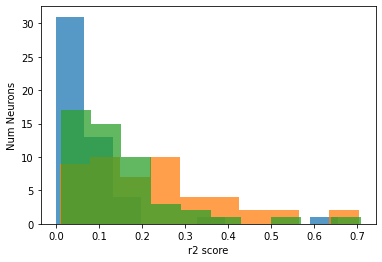

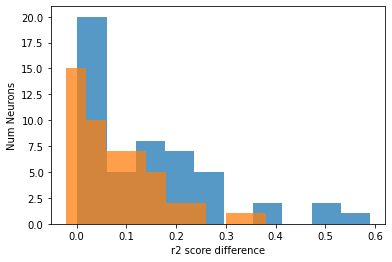

In [11]:
all_r2s_first= np.zeros(data.shape[-1])
for n in range(fr_binned.shape[-1]):
    X2 = np.hstack([features, fr_binned[:, 0, n:n+1]])
    model.fit(X2, Y[:, n])
    y_pred = model.predict(X2)
    all_r2s_first[n] = r2_score(Y[:, n], y_pred, multioutput = 'raw_values')[0]
plt.hist(all_r2s, alpha = .75)
plt.hist(all_r2s_prev, alpha = .75)
plt.hist(all_r2s_first, alpha = .75)

plt.xlabel("r2 score")
plt.ylabel("Num Neurons")
plt.show()
plt.hist(all_r2s_prev - all_r2s, alpha = .75)
plt.hist(all_r2s_prev - all_r2s_first, alpha = .75)

plt.xlabel("r2 score difference")
plt.ylabel("Num Neurons");

In [12]:
fr_binned.shape

(600, 10, 50)

What if we use the shuffled data with bootstraping? (excluding 1000-1600 ms) 

In [13]:
num_tests = 200
all_r2s_rand = np.zeros([num_tests, data.shape[-1]])
all_random_fr_binned = np.zeros([num_tests, fr_binned.shape[0], fr_binned.shape[-1]])
data_trial_other_windows = np.delete(data_trial, np.arange(1000, 1600), axis = 1)
order = np.arange(data_trial_other_windows.shape[1])
for i in range(num_tests):
    np.random.shuffle(order)
    all_random_fr_binned[i] = (1000 / fr_window) * np.sum(data_trial_other_windows[:, order[:fr_window], :], axis = 1)
    for n in range(fr_binned.shape[-1]):
        X2 = np.hstack([features, all_random_fr_binned[i, :, n:n+1]])
        model.fit(X2, Y[:, n])
        y_pred = model.predict(X2)
        all_r2s_rand[i, n] = r2_score(Y[:, n], y_pred, multioutput = 'raw_values')[0]

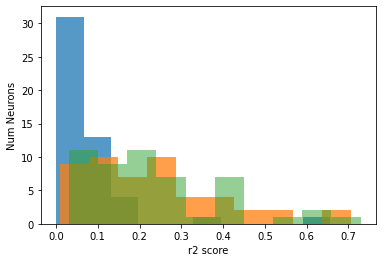

Text(0, 0.5, 'Num Neurons')

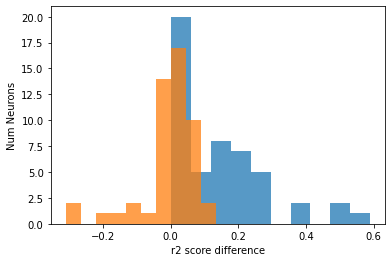

In [14]:
import scipy
#### difference with mean 
all_r2s_rand_mean = np.mean(all_r2s_rand, axis = 0)
plt.hist(all_r2s, alpha = .75)
plt.hist(all_r2s_prev, alpha = .75)
plt.hist(all_r2s_rand_mean, alpha = .5)

plt.xlabel("r2 score")
plt.ylabel("Num Neurons");
plt.show()
plt.hist(all_r2s_prev - all_r2s, alpha = .75)
plt.hist(all_r2s_prev - all_r2s_rand_mean, alpha = .75)
plt.xlabel("r2 score difference")
plt.ylabel("Num Neurons")



In [15]:
sig_neurons = []
for n in range(data.shape[-1]):
    if np.quantile(all_r2s_prev[n] - all_r2s_rand[:, n], .05) > 0:
        sig_neurons.append(n)

print(sig_neurons)
all_r2s_prev[sig_neurons] - all_r2s_rand_mean[sig_neurons] 

[2, 5, 7, 11, 12, 16, 18, 19, 21, 22, 25, 27, 28, 30, 37, 38, 44, 46, 47]


array([0.105059  , 0.13429148, 0.07563075, 0.07639806, 0.08966704,
       0.0338322 , 0.02719134, 0.06464557, 0.02790467, 0.06989042,
       0.06347203, 0.0706486 , 0.05690911, 0.03997252, 0.04370349,
       0.05001939, 0.04533556, 0.05269074, 0.04190524])

What is the r2 as the function of difference between time bins? 

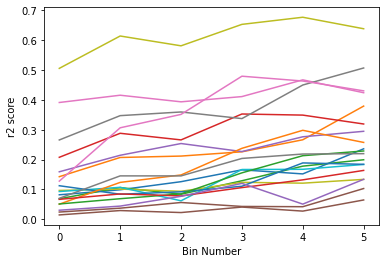

In [16]:
all_r2s_bins= np.zeros([6, data.shape[-1]])

for n in sig_neurons: #range(fr_binned.shape[-1]):
    for i in range(all_r2s_bins.shape[0]):
        X2 = np.hstack([features, fr_binned[:, i, n:n+1]])
        model.fit(X2, Y[:, n])
        y_pred = model.predict(X2)
        all_r2s_bins[i, n] = r2_score(Y[:, n], y_pred, multioutput = 'raw_values')[0]
#plot_r2 = np.delete(all_r2s_bins, 6 , axis = 0)
plot_r2 = all_r2s_bins[:, sig_neurons]
plt.plot(plot_r2)
plt.ylabel("r2 score")
plt.xlabel("Bin Number");

What if we add other neruons?

In [17]:
X2 = np.hstack([features, fr_binned[:, 5, :]])
model.fit(X2, Y)
y_pred = model.predict(X2)
all_r2s_prev_pop = r2_score(Y, y_pred, multioutput = 'raw_values')

Text(0.5, 0, 'r2_score')

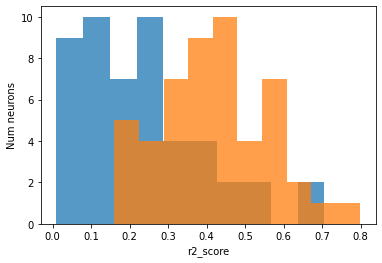

In [18]:
plt.hist(all_r2s_prev, alpha = .75)
plt.hist(all_r2s_prev_pop, alpha = .75)
plt.ylabel("Num neurons")
plt.xlabel("r2_score")

Now lets consider more time_bins in our analysis

In [19]:
X = fr_binned[:, 1, :]
Y = fr_binned[:, 2, :]
F = features
for i in range (2, fr_binned.shape[1] - 2):
    X = np.vstack([X, fr_binned[:, i, :]])
    Y = np.vstack([Y, fr_binned[:, i+1, :]])
    F = np.vstack([F, features])
X2 = np.hstack([F, X])
model.fit(X2, Y)
y_pred = model.predict(X2)
all_r2s_all_time = r2_score(Y, y_pred, multioutput = 'raw_values')

(array([ 2.,  7.,  9., 12.,  6.,  5.,  5.,  1.,  1.,  2.]),
 array([0.08683368, 0.1510516 , 0.21526951, 0.27948742, 0.34370534,
        0.40792325, 0.47214116, 0.53635908, 0.60057699, 0.6647949 ,
        0.72901282]),
 <BarContainer object of 10 artists>)

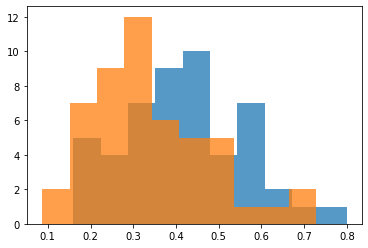

In [20]:
plt.hist(all_r2s_prev_pop, alpha = .75)
plt.hist(all_r2s_all_time, alpha = .75)


Do we really need all other neruons? 

In [21]:
from sklearn import linear_model
model = linear_model.Lasso(alpha = 2.5)
model.fit(X2, Y)
y_pred = model.predict(X2)
all_r2s_all_time_sparse = r2_score(Y, y_pred, multioutput = 'raw_values')
print ("non-zero ratio:", 1 - np.where(model.coef_ == 0)[0].size / model.coef_.size)

non-zero ratio: 0.3381481481481482


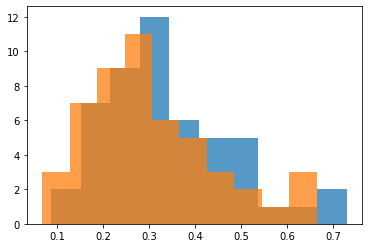

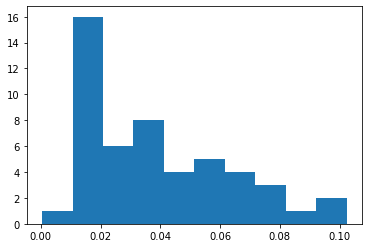

In [22]:
plt.hist(all_r2s_all_time, alpha = .75)
plt.hist(all_r2s_all_time_sparse, alpha = .75)
plt.show()
plt.hist(all_r2s_all_time - all_r2s_all_time_sparse);

With around 1/3rd of the population we get almost the same results.

# TODO: Decoding approach